# AlexNet model

### AlexNet with TIRADS

## Get packages

In [1]:
import tensorflow as tf
import os
import random
import numpy as np
from tqdm import tqdm
import albumentations as A
import cv2

from skimage.io import imread
from skimage.io import imshow
from skimage.util import crop
from skimage.transform import resize
import matplotlib.pyplot as plt


from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers.legacy import Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.layers import *
from keras import models
from keras.preprocessing import image

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Paths

In [2]:
TRAIN_PATH = 'archive/classification/tirads/train'
TEST_PATH = 'archive/classification/tirads/test'
VALID_PATH = 'archive/classification/tirads/validate'

In [3]:
input_size = (3,227,227)

## Load and Prepare Images

In [5]:
from keras.preprocessing.image import ImageDataGenerator

# train_batchsize = 4
# valid_batchsize = 4
# S-a folosit din totalul datelor 25% pentru validare si 75% pt testare
train_datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=0.6)

validation_datagen = ImageDataGenerator()
                                  

train_generator = train_datagen.flow_from_directory(
        TRAIN_PATH,  
        shuffle=True,
#          batch_size=train_batchsize,
        target_size=input_size[1:],
        class_mode='categorical')  

validation_generator = validation_datagen.flow_from_directory(
        VALID_PATH,  
        target_size=input_size[1:],
        shuffle=True,
#          batch_size=valid_batchsize,
        class_mode='categorical')

Found 522 images belonging to 6 classes.
Found 174 images belonging to 6 classes.


## Make the model

In [185]:
#Instantiate an empty model
model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(filters=32, input_shape=(224,224,3), kernel_size=(11,11), strides=(4,4), padding="valid"))
model.add(Activation('relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# 2nd Convolutional Layer
model.add(Conv2D(filters=64, kernel_size=(11,11), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# 3rd Convolutional Layer
model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))

# 4th Convolutional Layer
model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))

# 5th Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# Passing it to a Fully Connected layer
model.add(Flatten())
# 1st Fully Connected Layer
model.add(Dense(200, input_shape=(224*224*3,)))
model.add(Activation('relu'))
# Add Dropout to prevent overfitting
model.add(Dropout(0.25))

# 2nd Fully Connected Layer
model.add(Dense(100))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.2))

# 3rd Fully Connected Layer
model.add(Dense(50))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.1))

# Output Layer
model.add(Dense(6))
model.add(Activation('softmax'))

model.summary()

# Compile the model
model.compile(
              loss=keras.losses.CategoricalFocalCrossentropy(), 
#               loss=keras.losses.BinaryCrossentropy(),
              optimizer=keras.optimizers.legacy.Adam(learning_rate=0.0004), 
              metrics=['accuracy',
#               keras.metrics.BinaryAccuracy(),
#               keras.metrics.FalseNegatives(),
                      ],
             )

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_185 (Conv2D)         (None, 54, 54, 32)        11648     
                                                                 
 activation_333 (Activation  (None, 54, 54, 32)        0         
 )                                                               
                                                                 
 max_pooling2d_111 (MaxPool  (None, 27, 27, 32)        0         
 ing2D)                                                          
                                                                 
 conv2d_186 (Conv2D)         (None, 17, 17, 64)        247872    
                                                                 
 activation_334 (Activation  (None, 17, 17, 64)        0         
 )                                                               
                                                     

In [7]:
train_generator.class_indices

{'2': 0, '3': 1, '4a': 2, '4b': 3, '4c': 4, '5': 5}

## Train the model

In [188]:
# Se antreneaza modelul
checkpoiter = tf.keras.callbacks.ModelCheckpoint('model_alexnet_tirads_aug.h5', verbose=1, save_best_only=True)

callbacks = [
#     tf.keras.callbacks.EarlyStopping(patience=7, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs'),
    checkpoiter

]

results = model.fit(train_generator, 
                    validation_data=validation_generator,
#                     validation_split=0.1, 
                    batch_size=32, 
                    epochs=25, 
                    callbacks=callbacks,
                   )

Epoch 1/25
17/17 [==============================] - ETA: 0s - loss: 0.2659 - accuracy: 0.2874
Epoch 1: val_loss improved from inf to 0.29823, saving model to model_alexnet_tirads_aug.h5
17/17 [==============================] - 4s 228ms/step - loss: 0.2659 - accuracy: 0.2874 - val_loss: 0.2982 - val_accuracy: 0.1609
Epoch 2/25
17/17 [==============================] - ETA: 0s - loss: 0.2742 - accuracy: 0.2625
Epoch 2: val_loss improved from 0.29823 to 0.28683, saving model to model_alexnet_tirads_aug.h5
17/17 [==============================] - 4s 225ms/step - loss: 0.2742 - accuracy: 0.2625 - val_loss: 0.2868 - val_accuracy: 0.2126
Epoch 3/25
17/17 [==============================] - ETA: 0s - loss: 0.2623 - accuracy: 0.2950
Epoch 3: val_loss did not improve from 0.28683
17/17 [==============================] - 4s 219ms/step - loss: 0.2623 - accuracy: 0.2950 - val_loss: 0.2941 - val_accuracy: 0.2069
Epoch 4/25
17/17 [==============================] - ETA: 0s - loss: 0.2641 - accuracy: 0.3

## Results

In [189]:
print('Accuracy Score = ',np.max(results.history['val_accuracy']))
print('Loss Score = ',np.min(results.history['val_loss']))

Accuracy Score =  0.27586206793785095
Loss Score =  0.2868264317512512


### During training

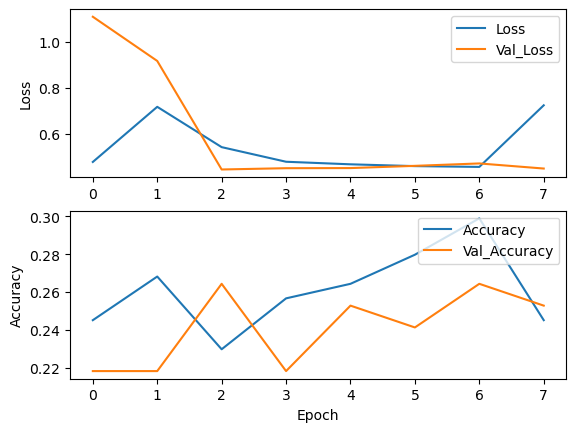

In [80]:
plt.figure()
plt.subplot(211)
loss_train_curve = results.history["loss"]
loss_val_curve = results.history["val_loss"]
plt.plot(loss_train_curve, label = "Loss")
plt.plot(loss_val_curve, label = "Val_Loss")
plt.legend(loc = 'upper right')
plt.ylabel("Loss")


plt.subplot(212)
acc_train_curve = results.history["accuracy"]
acc_val_curve = results.history["val_accuracy"]
plt.plot(acc_train_curve, label = "Accuracy")
plt.plot(acc_val_curve, label = "Val_Accuracy")
plt.legend(loc = 'upper right')
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()